# MNIST example

This notebook provides a proof of concept for our framework, assuming this very simple instance of the framework:

- The data layer is composed by 10 classifiers, one per each digit of the MNIST dataset, i.e., one classifier that recognizes zeroes, one that recognizes ones, and so on.

- The Ontology alphabet contains one class per each digit (Zero, One, Two, ..., Nine), and the theory is empty

- The mapping maps each classifier to the class it recognizes

The proof of concept is structured as follows:

1. Train the 10 classifiers (MLPs)

2. Transform the query into a system of inequalities

3. Solve the system, and show a witness is the system is satisfiable

# **1. Build the Classifiers**

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Subset

import numpy as np
import matplotlib.pyplot as plt
import os

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

Using PyTorch version: 2.7.0+cu128
Using GPU, device name: NVIDIA T550 Laptop GPU


In [2]:
batch_size = 32

data_dir = './data'

train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST(data_dir, train=False, transform=ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

posTests = []
for i in range(10):
  indices = [j for j, (img, label) in enumerate(test_dataset) if label == i]
  ds = Subset(test_dataset, indices)
  posTests.append(DataLoader(dataset=ds, batch_size=batch_size, shuffle=False))

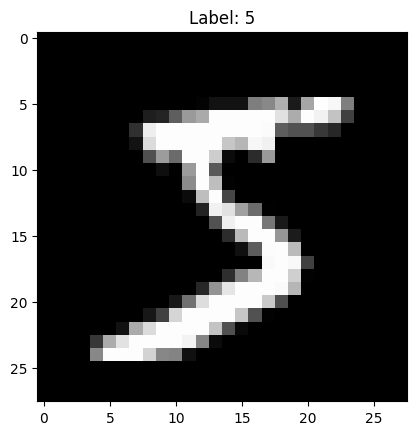

In [3]:
first_sample = train_dataset[0]
image, label = first_sample
image_np = image.numpy().squeeze()

#print image
plt.imshow(image_np, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

#print tensor
#print(image)

In [67]:
in_size = 28*28
h_size = 2
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_size, h_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(h_size, 1)

    def forward(self, x):
        x = x.view(-1, in_size)
        y1 = self.fc1(x)
        y2 = self.relu(y1)
        y3 = self.fc2(y2)
        return y3

models = []
criterions = []
optimizers = []

pos_weight = torch.tensor([9.0]).to(device) #peso ai sample positivi per contrastare sbilanciamento dataset (istanze positive sono solo il 10% del dataset)

for i in range(10):
  models.append(SimpleMLP().to(device))
  criterions.append(nn.BCEWithLogitsLoss(pos_weight=pos_weight))
  optimizers.append(torch.optim.Adam(models[i].parameters()))
print(models)
print(criterions)
print(optimizers)

[SimpleMLP(
  (fc1): Linear(in_features=784, out_features=2, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=2, out_features=1, bias=True)
), SimpleMLP(
  (fc1): Linear(in_features=784, out_features=2, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=2, out_features=1, bias=True)
), SimpleMLP(
  (fc1): Linear(in_features=784, out_features=2, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=2, out_features=1, bias=True)
), SimpleMLP(
  (fc1): Linear(in_features=784, out_features=2, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=2, out_features=1, bias=True)
), SimpleMLP(
  (fc1): Linear(in_features=784, out_features=2, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=2, out_features=1, bias=True)
), SimpleMLP(
  (fc1): Linear(in_features=784, out_features=2, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=2, out_features=1, bias=True)
), SimpleMLP(
  (fc1): Linear(in_features=784, out_features=2, bias=True)
  (relu): ReLU()
  (fc2): Linear(i

In [68]:
def correct(output, target):
    predicted_digits = torch.heaviside(output, torch.tensor([1.0]).to(device)) #se output>=0 allora ritorna 1, altrimenti 0
    correct_ones = (predicted_digits == target).type(torch.float) #vettore con 1 dove la predizione era corretta, 0 dove era sbagliata
    return correct_ones.sum().item() #conta i corretti

In [69]:
def train(data_loader, model, criterion, optimizer, classNumber):
    model.train()

    num_batches = len(data_loader)
    num_items = len(data_loader.dataset)

    total_loss = 0
    total_correct = 0
    for data, target in data_loader:
        # Copy data and targets to GPU
        data = data.to(device)
        target = target.to(device)
        '''
        for image, label in zip(data, target):
          print(image)
          image_np = image.numpy().squeeze()
          plt.imshow(image_np, cmap='gray')
          plt.title(f"Label: {label}")
          plt.show()
        '''
        # converte le label in 1 per il valore scelto e 0 per tutti gli altri valori
        #print(f"label originali: {target}")
        target = (target == classNumber).type(torch.float).reshape(-1, 1)
        #print("label convertite:", target.flatten())

        output = model(data)
        #print("prediction: ", output.flatten())
        loss = criterion(output, target)
        total_loss += loss

        total_correct += correct(output, target)
        #print("azzeccate: ", correct(output, target))
        #print("azzeccate: ", total_correct)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = total_loss/num_batches
    accuracy = total_correct/num_items
    print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}")


In [70]:
def test(test_loader, model, criterion, classNumber):
    model.eval()

    num_batches = len(test_loader)
    num_items = len(test_loader.dataset)

    test_loss = 0
    total_correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            # Copy data and targets to GPU
            data = data.to(device)
            target = (target == classNumber).type(torch.float).reshape(-1, 1)
            target = target.to(device)
            # Do a forward pass
            output = model(data)

            # Calculate the loss
            loss = criterion(output, target)
            test_loss += loss.item()

            # Count number of correct digits
            total_correct += correct(output, target)

    test_loss = test_loss/num_batches
    accuracy = total_correct/num_items

    print(f"Testset accuracy: {100*accuracy:>0.1f}%, average loss: {test_loss:>7f}")

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, data_loader, classNumber, device='cuda'):
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            binary_labels = (labels == classNumber).int()
            outputs = model(images).view(-1)
            preds = (outputs >= 0).int()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(binary_labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["non-"+str(classNumber), str(classNumber)])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f"Confusion Matrix for class {classNumber}")
    plt.show()

## Classifier for Zeroes

In [71]:
%%time

epochs = 3
for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    train(train_loader, models[0], criterions[0], optimizers[0], 0)

Training epoch: 1
Average loss: 0.215302, accuracy: 94.39%
Training epoch: 2
Average loss: 0.098455, accuracy: 98.17%
Training epoch: 3
Average loss: 0.090233, accuracy: 98.29%
CPU times: user 47 s, sys: 283 ms, total: 47.3 s
Wall time: 45.1 s


In [72]:
test(test_loader, models[0], criterions[0], 0)
test(posTests[0], models[0], criterions[0], 0)

Testset accuracy: 98.6%, average loss: 0.078307
Testset accuracy: 99.0%, average loss: 0.361436


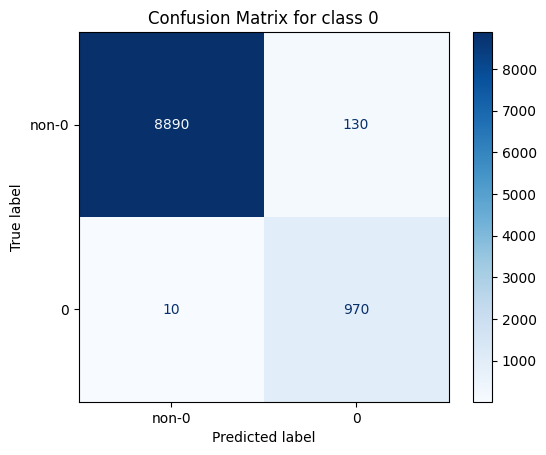

In [73]:
plot_confusion_matrix(models[0], test_loader, 0)

In [19]:
def disegna(arr):
  tens = torch.tensor(arr)
  img = np.array(tens, dtype=np.uint8).reshape((28, 28))
  img = np.array(img).reshape((28, 28))
  plt.imshow(img, cmap='gray', vmin=0, vmax=255)
  plt.axis('off')
  plt.title(f"esempio 0")
  plt.show()
  print(arr)

In [52]:
def is0(img_array):
    disegna(img_array)
    out = models[0](torch.FloatTensor(img_array).to(device))
    print(out)
    prediction = torch.heaviside(out, torch.tensor([1.0]).to(device))
    print("è uno 0?")
    if prediction==0:
        print("NO!")
    else:
        print("YES!")

/tmp/ipykernel_4065/378609832.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img = np.array(tens, dtype=np.uint8).reshape((28, 28))


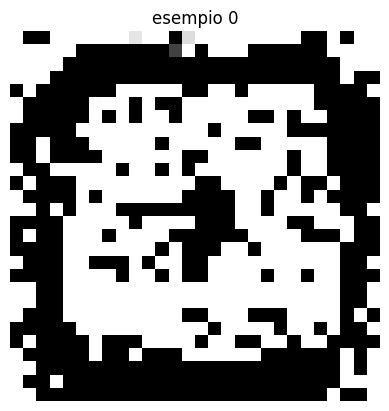

[255, 0, 0, 255, 255, 255, 255, 255, 255, 229, 255, 255, 0, 221, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 0, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 65, 255, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 255, 255, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 253, 255, 255, 0, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 255, 0, 255, 255, 0, 255, 255, 255, 255, 255, 0, 0, 255, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0

In [74]:
ex02 = [255, 0, 0, 0, 0, 249, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 255, 255, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 1, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 255, 0, 0, 0, 0, 255, 0, 0, 255, 255, 0, 0, 0, 0, 97, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255]
ex = [255, 0, 0, 255, 255, 255, 255, 255, 255, 229, 255, 255, 0, 221, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 0, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 65, 255, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 255, 255, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 253, 255, 255, 0, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 255, 0, 255, 255, 0, 255, 255, 255, 255, 255, 0, 0, 255, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 255, 255, 255, 255, 255, 0, 255, 255, 0, 255, 0, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 0, 255, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 255, 255, 0, 255, 255, 0, 255, 0, 0, 0, 0, 255, 255, 0, 255, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 255, 255, 255, 255, 255, 0, 0, 255, 0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 0, 0, 255, 255, 255, 0, 0, 0, 255, 0, 0, 255, 255, 255, 0, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 0, 255, 0, 0, 0, 255, 255, 0, 255, 255, 255, 255, 255, 255, 0, 0, 0, 255, 0, 0, 0, 255, 255, 0, 0, 0, 255, 0, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 0, 0, 0, 0, 255, 255, 255, 255, 0, 255, 255, 0, 255, 0, 0, 255, 255, 255, 255, 0, 255, 255, 0, 255, 255, 0, 0, 0, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 0, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 0, 255, 255, 0, 255, 0, 0, 255, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 255, 255, 255, 255, 0, 255, 255, 0, 0, 255, 255, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 255, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255]
is0(ex)

## Classifier for Ones

In [16]:
%%time

epochs = 10
for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    train(train_loader, models[1], criterions[1], optimizers[1], 1)

Training epoch: 1
Average loss: 0.085504, accuracy: 98.59%
Training epoch: 2
Average loss: 0.045937, accuracy: 99.15%
Training epoch: 3
Average loss: 0.036273, accuracy: 99.32%
Training epoch: 4
Average loss: 0.028207, accuracy: 99.51%
Training epoch: 5
Average loss: 0.023200, accuracy: 99.55%
Training epoch: 6
Average loss: 0.018636, accuracy: 99.63%
Training epoch: 7
Average loss: 0.015461, accuracy: 99.69%
Training epoch: 8
Average loss: 0.012248, accuracy: 99.75%
Training epoch: 9
Average loss: 0.009898, accuracy: 99.80%
Training epoch: 10
Average loss: 0.007703, accuracy: 99.83%
CPU times: user 1min 20s, sys: 703 ms, total: 1min 21s
Wall time: 1min 19s


Testset accuracy: 99.6%, average loss: 0.032502


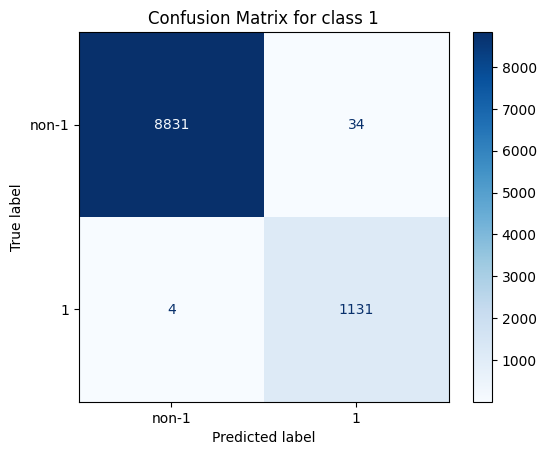

In [17]:
test(test_loader, models[1], criterions[1], 1)
plot_confusion_matrix(models[1], test_loader, 1)

## Classifier for Twos

In [18]:
%%time

epochs = 10
for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    train(train_loader, models[2], criterions[2], optimizers[2], 2)

Training epoch: 1
Average loss: 0.184222, accuracy: 96.89%
Training epoch: 2
Average loss: 0.078135, accuracy: 98.70%
Training epoch: 3
Average loss: 0.053315, accuracy: 99.04%
Training epoch: 4
Average loss: 0.040321, accuracy: 99.27%
Training epoch: 5
Average loss: 0.028551, accuracy: 99.48%
Training epoch: 6
Average loss: 0.023600, accuracy: 99.58%
Training epoch: 7
Average loss: 0.016779, accuracy: 99.67%
Training epoch: 8
Average loss: 0.012514, accuracy: 99.75%
Training epoch: 9
Average loss: 0.012351, accuracy: 99.73%
Training epoch: 10
Average loss: 0.011255, accuracy: 99.78%
CPU times: user 1min 20s, sys: 712 ms, total: 1min 20s
Wall time: 1min 19s


Testset accuracy: 99.5%, average loss: 0.064144


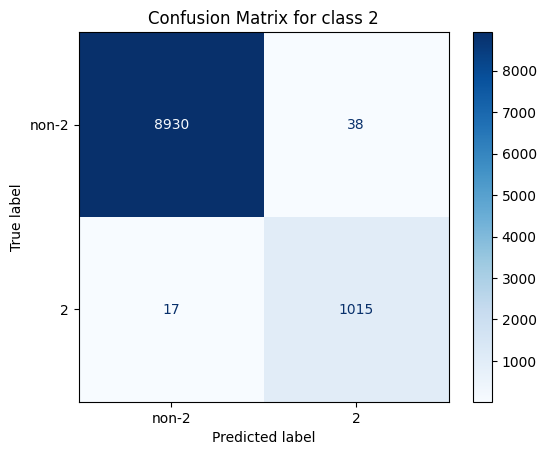

In [19]:
test(test_loader, models[2], criterions[2], 2)
plot_confusion_matrix(models[2], test_loader, 2)

## Verifica parametri

In [21]:
for param in models[0].parameters():
  print(param.size())

from torchsummary import summary
summary(models[0], input_size=(batch_size, 1, 28, 28))
model = models[0]
print(list(model.parameters())[0].data)
print(list(model.parameters())[1].data)
print(list(model.parameters())[2].data)
print(list(model.parameters())[3].data)

torch.Size([64, 784])
torch.Size([64])
torch.Size([1, 64])
torch.Size([1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]          50,240
              ReLU-2                   [-1, 64]               0
            Linear-3                    [-1, 1]              65
Total params: 50,305
Trainable params: 50,305
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 0.00
Params size (MB): 0.19
Estimated Total Size (MB): 0.29
----------------------------------------------------------------
tensor([[-0.0256,  0.0303,  0.0054,  ...,  0.0042,  0.0202,  0.0237],
        [ 0.0011,  0.0126, -0.0134,  ..., -0.0127,  0.0345,  0.0120],
        [ 0.0083, -0.0282,  0.0194,  ...,  0.0065,  0.0048, -0.0086],
        ...,
        [-0.0146, -0.0277, -0.0282,  ..., -0.0085, -0.0339, -0.007

# **2. Codifica Z3**

In [25]:
from z3 import *

In [26]:
def draw(witness, x_vars, title):
  witness_values = [witness[x_var].as_long() for x_var in x_vars]
  witness_tensor = torch.tensor(witness_values)
  witness_img = np.array(witness_tensor, dtype=np.uint8).reshape((28, 28))
  witness_img = np.array(witness_img).reshape((28, 28))
  plt.imshow(witness_img, cmap='gray', vmin=0, vmax=255)
  plt.axis('off')
  plt.title(f"{title}")
  plt.show()
  print(witness_values)

In [86]:
def check(q):
  s = Solver()
  h_size = 2

  x_vars = [Int(f'x_{i}') for i in range(in_size)]# crea variabili (una per ogni pixel: 28*28=784)
  #s.add(Sum([ x_vars[i] for i in range(in_size)]) >= 20000)
  for x in x_vars:
    s.add(x >= 0)
    s.add(x <= 255)

  for model in q:
    W_1 = list(model.parameters())[0].data
    W_1 = torch.transpose(W_1, 0, 1)
    b_1 = list(model.parameters())[1].data
    W_2 = list(model.parameters())[2].data
    b_2 = list(model.parameters())[3].data
    W_2 = torch.flatten(W_2)
    b_2 = b_2.item()


    # Somma del primo layer (combinazione lineare)

    y1 = []
    print("codifico primo layer")
    for j in range(h_size):
      weighted_sum = Sum([ x_vars[i] * RealVal(W_1[i][j].item()) for i in range(in_size)])
      y1_j = weighted_sum + RealVal(b_1[j].item())
      y1.append(y1_j)
    print("FATTO primo layer")
    print("codifico secondo layer")
    y2 = [If(y1[j]>0, y1[j], 0) for j in range(h_size)] #relu effettiva
    #y2 = y1 #salto layer non lineare
    '''
    #approssimo la relu
    y2 = []
    for j in range(h_size):
        y = Real(f'y2_{j}')
        s.add(Or(y >= 0, y >= y1[j])) #approssimazione della relu
        y2.append(y)
    '''
    print("FATTO secondo layer")
    print("codifico terzo layer")
    y3 = Sum([RealVal(W_2[j].item()) * y2[j] for j in range(h_size)]) + RealVal(b_2)
    print("FATTO terzo layer")

    s.add(y3 >= 0)

  #print("questa è l'equazione che ho costruito")
  #print(print(s.sexpr()))
  # verifico se è satisfiable, ovvero se esiste una soluzione al sistema di disequazioni

  
  print("lancio il solver")
  res = s.check()
  print(res)

  #solutions = []
  #step = 19992
  #for j in range(10):
    #if j > 0:
      #for k in range(j):
          #s.add(Sum([x_vars[i] for i in range(len(x_vars))]) >= step*k)

  if res == sat:
    print("cerco il witness")
    witness = s.model()
    #solutions.append(witness)
    #draw(witness, x_vars, "witness")
    witness_values = [witness[x_var].as_long() for x_var in x_vars]
    is0(witness_values)
  


codifico primo layer
FATTO primo layer
codifico secondo layer
FATTO secondo layer
codifico terzo layer
FATTO terzo layer
lancio il solver
sat
cerco il witness


/tmp/ipykernel_4065/378609832.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img = np.array(tens, dtype=np.uint8).reshape((28, 28))


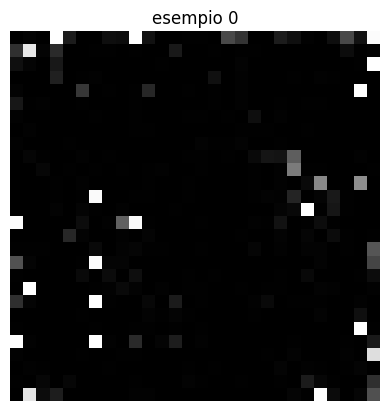

[0, 3, 0, 255, 28, 0, 0, 14, 12, 255, 17, 0, 0, 1, 1, 0, 73, 53, 0, 0, 28, 15, 2, 0, 14, 72, 18, 252, 48, 232, 4, 42, 0, 0, 1, 1, 0, 1, 0, 0, 25, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 12, 1, 3, 15, 4, 0, 24, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 255, 0, 0, 0, 32, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 2, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 3, 0, 0, 0, 0, 55, 0, 1, 0, 1, 39, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 23, 1, 2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 14, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 9, 21, 19, 94, 0, 0, 0, 0, 2, 0, 0, 0, 6, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 0, 1, 0, 0, 0, 1, 0, 2, 123, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0,

In [87]:
q0 = [models[0]]
check(q0)

/tmp/ipykernel_4065/378609832.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img = np.array(tens, dtype=np.uint8).reshape((28, 28))


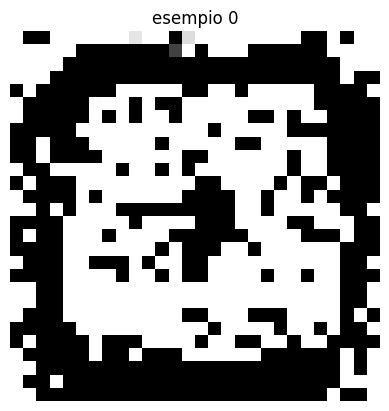

[255, 0, 0, 255, 255, 255, 255, 255, 255, 229, 255, 255, 0, 221, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 0, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 65, 255, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 255, 255, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 253, 255, 255, 0, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 255, 0, 255, 255, 0, 255, 255, 255, 255, 255, 0, 0, 255, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0

In [83]:
ex = [255, 0, 0, 255, 255, 255, 255, 255, 255, 229, 255, 255, 0, 221, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 0, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 65, 255, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 255, 255, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 253, 255, 255, 0, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 255, 0, 255, 255, 0, 255, 255, 255, 255, 255, 0, 0, 255, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 255, 255, 255, 255, 255, 0, 255, 255, 0, 255, 0, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 0, 255, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 255, 255, 0, 255, 255, 0, 255, 0, 0, 0, 0, 255, 255, 0, 255, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 255, 255, 255, 255, 255, 0, 0, 255, 0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 0, 0, 255, 255, 255, 0, 0, 0, 255, 0, 0, 255, 255, 255, 0, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 0, 255, 0, 0, 0, 255, 255, 0, 255, 255, 255, 255, 255, 255, 0, 0, 0, 255, 0, 0, 0, 255, 255, 0, 0, 0, 255, 0, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 0, 0, 0, 0, 255, 255, 255, 255, 0, 255, 255, 0, 255, 0, 0, 255, 255, 255, 255, 0, 255, 255, 0, 255, 255, 0, 0, 0, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 0, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 0, 255, 255, 0, 255, 0, 0, 255, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 255, 255, 255, 255, 0, 255, 255, 0, 0, 255, 255, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 255, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255]
is0(ex)

#comment

In [27]:
def check_comment(q):
  #f = getFormula(q)
  s = Solver()

  x_vars = [Int(f'x_{i}') for i in range(784)]# crea variabili (una per ogni pixel: 28*28=784)
  for x in x_vars:
    s.add(x >= 0)
    s.add(x <= 255)

  for model in q:
    W_1 = list(model.parameters())[0].data
    b_1 = list(model.parameters())[1].data
    #W_1 = torch.flatten(W_1)
    #b_1 = torch.flatten(b_1)
    W_2 = list(model.parameters())[2].data
    b_2 = list(model.parameters())[3].data
    W_2 = torch.flatten(W_2)
    b_2 = b_2.item()


    # Somma del primo layer (combinazione lineare)
    y1 = [Sum([W_1[j][i].item() * x[i].item() for i in range(784)]) + b_1[j].item() for j in range(128)]

    # Applicazione della ReLU
    y2 = [If(y1[j].item()>0, y1[j].item(), 0) for j in range(128)]

    # Combinazione lineare del secondo layer
    y3 = Sum([W_2[j].item() * y2[j].item() for j in range(128)]) + b_2

    s.add(y3 >= 0)

    #W_1 = torch.transpose(W_1)
    #y_1 = [Sum([RealVal(W_1[i].item())] * x_vars[j] for i in range(128) and j in range(784))]
    #expr = Sum([RealVal(W_2[i].item()) * y_1[i] for i in range(len(W_2))]) # combinazione lineare variabili e pesi in W
    #print(expr.sexpr())
    #s.add(expr + b >= 0) # formula finale (W*x + b >= 0)


  # verifico se è satisfiable, ovvero se esiste una soluzione al sistema di disequazioni
  res = s.check()
  print(res)

  solutions = []
  step = 19992
  for j in range(10):
    # Reset the solver before each iteration
    #s.reset()
    #s.add(And(sys))
    # add constraints of previous solutions
    if j > 0:
      for k in range(j):
          #hamming_dist = Sum([If(x_vars[i] != solutions[k][x_vars[i]], 1, 0) for i in range(len(x_vars))])
          #s.add(hamming_dist >= 50)
          #s.add(Or([x_vars[i] != solutions[k][x_vars[i]] for i in range(len(x_vars))]))
          s.add(Sum([x_vars[i] for i in range(len(x_vars))]) >= step*k)

    if s.check() == sat:
      witness = s.model()
      solutions.append(witness)
      draw(witness, x_vars, j)

'''

  if (res == 'unsat'):
    return False
  else:
    witness = s.model()
    print("Witness trovato:")
    #print(values)
    #print (sorted ([(d, witness[d]) for d in witness], key = lambda x: str(x[0])))
    #for val in witness:
      #print(f"{val} = {witness[val]}")

    witness_pairs = [(x_var, witness[x_var].as_long()) for x_var in x_vars]
    witness_values = [witness[x_var].as_long() for x_var in x_vars]

    for val, pes in zip(witness_pairs, W):
      if val[1] != 0:
        print("variabile ", val[0], " | valore ", val[1], " | peso ", pes)
    #witness_values = [float(val.numerator) / float(val.denominator) if val.denominator != 0 else 0 for val in witness_values]
    #witness_values = [witness[x_var].as_fraction() for x_var in x_vars]
    #witness_values = [float(val.numerator) / float(val.denominator) if val.denominator != 0 else 0 for val in witness_values]

    witness_tensor = torch.tensor(witness_values)
    print(witness_tensor)

    witness_img = np.array(witness_tensor, dtype=np.uint8).reshape((28, 28))
    witness_img = np.array(witness_img).reshape((28, 28))

    plt.imshow(witness_img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.show()

    return True
'''

'\n\n  if (res == \'unsat\'):\n    return False\n  else:\n    witness = s.model()\n    print("Witness trovato:")\n    #print(values)\n    #print (sorted ([(d, witness[d]) for d in witness], key = lambda x: str(x[0])))\n    #for val in witness:\n      #print(f"{val} = {witness[val]}")\n\n    witness_pairs = [(x_var, witness[x_var].as_long()) for x_var in x_vars]\n    witness_values = [witness[x_var].as_long() for x_var in x_vars]\n\n    for val, pes in zip(witness_pairs, W):\n      if val[1] != 0:\n        print("variabile ", val[0], " | valore ", val[1], " | peso ", pes)\n    #witness_values = [float(val.numerator) / float(val.denominator) if val.denominator != 0 else 0 for val in witness_values]\n    #witness_values = [witness[x_var].as_fraction() for x_var in x_vars]\n    #witness_values = [float(val.numerator) / float(val.denominator) if val.denominator != 0 else 0 for val in witness_values]\n\n    witness_tensor = torch.tensor(witness_values)\n    print(witness_tensor)\n\n    witne

#**3. Esempio esecuzione**

In [75]:
q0 = [models[0]]
check(q0)

Z3Exception: b'parser error'

sat


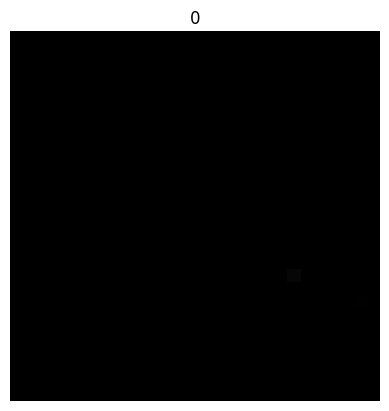

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

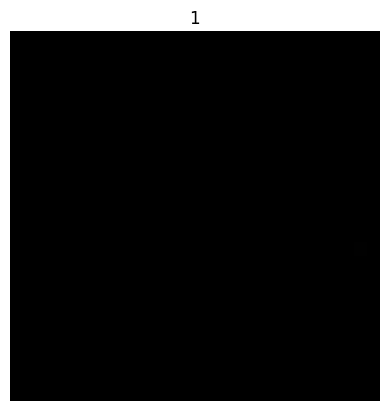

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

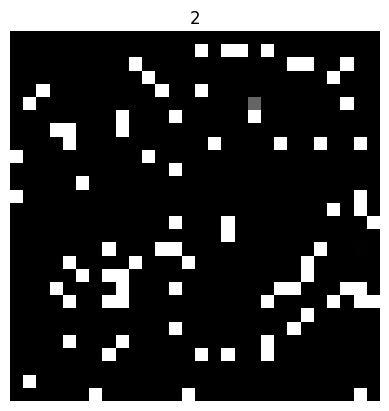

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

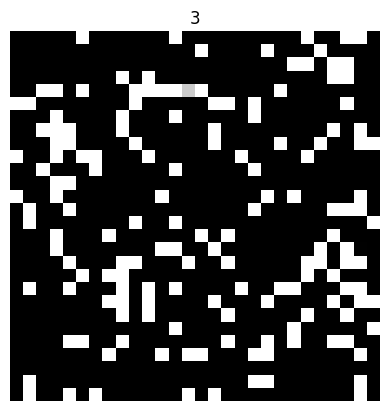

[0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 255, 0, 255, 0, 0, 0, 255, 255, 255, 255, 203, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 255, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0, 255, 255, 255, 0, 0, 255, 0, 255, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 2

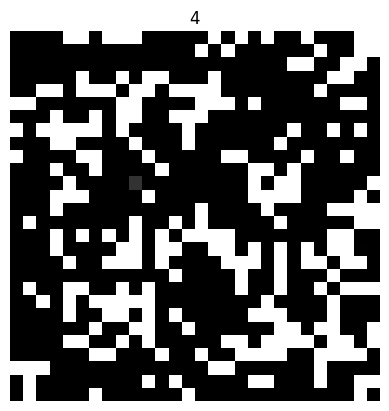

[0, 0, 0, 0, 255, 255, 0, 255, 255, 255, 0, 0, 0, 0, 0, 255, 0, 255, 0, 255, 0, 0, 255, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 0, 255, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 255, 0, 255, 255, 255, 0, 255, 255, 0, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 255, 255, 0, 255, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 255, 0, 255, 255, 0, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 255, 255, 255, 255, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 0, 255, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0,

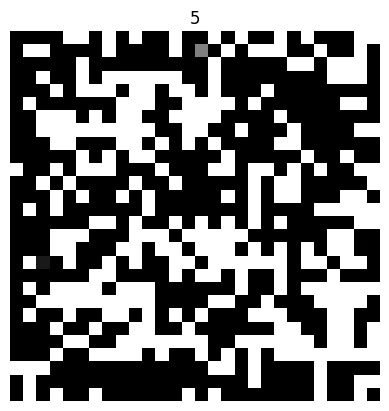

[0, 0, 0, 0, 255, 255, 0, 255, 0, 255, 0, 0, 255, 0, 0, 255, 0, 255, 0, 0, 255, 0, 255, 0, 0, 0, 255, 255, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 127, 0, 255, 0, 255, 255, 255, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 255, 0, 255, 255, 255, 0, 0, 0, 255, 0, 0, 255, 0, 255, 255, 255, 255, 255, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 255, 0, 255, 255, 255, 0, 255, 255, 0, 255, 255, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 255, 255, 255, 255, 0, 255, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 255, 255, 255, 0, 255, 0, 255, 255, 0, 0, 255, 255, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 255, 255, 0, 0, 0, 255, 255, 0, 0, 0, 255, 255, 0, 255, 0, 255, 0, 255, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 255, 255, 0, 0, 0,

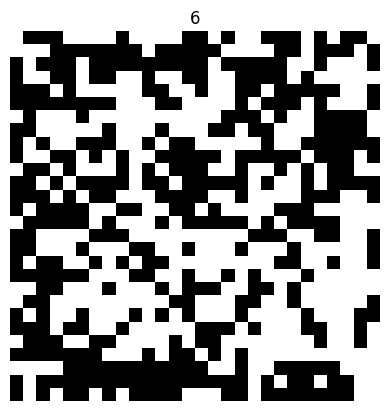

[255, 0, 0, 0, 255, 255, 255, 255, 0, 255, 255, 255, 255, 0, 0, 255, 0, 255, 255, 0, 0, 0, 255, 0, 255, 0, 0, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 255, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 255, 0, 255, 255, 255, 0, 0, 255, 255, 0, 0, 255, 0, 0, 255, 255, 0, 255, 255, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 255, 255, 255, 255, 255, 0, 0, 0, 255, 0, 255, 255, 255, 255, 255, 0, 0, 255, 255, 0, 255, 255, 0, 0, 255, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 255, 255, 255, 255, 0, 255, 0, 0, 0, 255, 0, 255, 255, 255, 0, 255, 0, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 255, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 255, 255, 255, 255, 255, 0, 255, 255, 255, 0, 255, 255, 255, 0, 0, 255, 0, 0, 255, 255, 255, 0, 0, 0, 0, 255, 0, 255, 0, 255, 255, 0, 0, 0, 255, 255, 0, 255, 0, 0, 255, 255, 255, 255, 255, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 

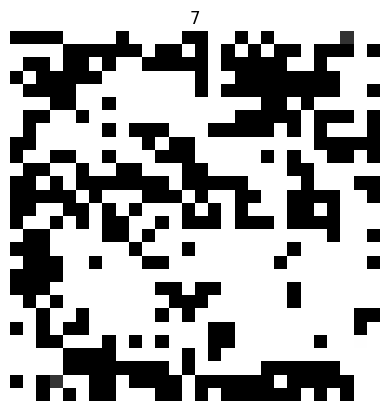

[0, 0, 0, 0, 255, 255, 255, 255, 0, 255, 255, 255, 255, 0, 0, 255, 255, 0, 255, 0, 255, 255, 255, 255, 255, 50, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 0, 255, 0, 255, 0, 255, 0, 0, 255, 0, 0, 0, 255, 0, 255, 0, 0, 255, 0, 0, 255, 0, 255, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 255, 0, 255, 255, 255, 255, 0, 255, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 255, 255, 255, 0, 0, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 0, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 255, 0, 255, 255, 255, 255, 255, 0, 255, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 0, 255, 0, 255, 0, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 0, 0, 255, 255, 255, 255, 255, 2

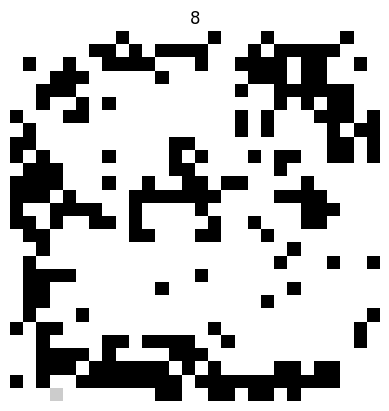

[255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 0, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 0, 255, 0, 0, 0, 0, 255, 255, 255, 0, 255, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 255, 255, 0, 255, 255, 0, 0, 0, 0, 255, 255, 255, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 255, 255, 0, 255, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 0, 0, 0, 255, 0, 0, 255, 255, 255, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 255, 255, 0, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 0, 255, 0, 0, 255, 255, 0, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 0, 255, 255, 255, 0, 0, 0, 255, 0, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 0, 255, 255, 255, 255, 0, 255, 0, 0, 0, 0, 255, 255, 255, 25

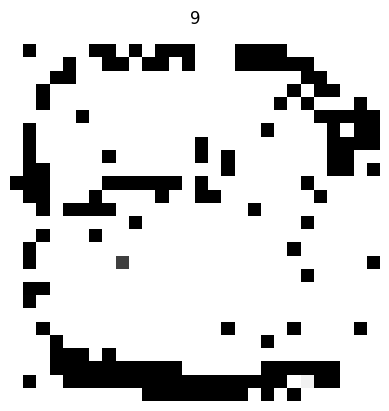

[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 0, 0, 255, 0, 255, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 0, 0, 255, 0, 0, 255, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 0, 0, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 0, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 

In [ ]:
q2 = [models[2]]
check(q2)

sat


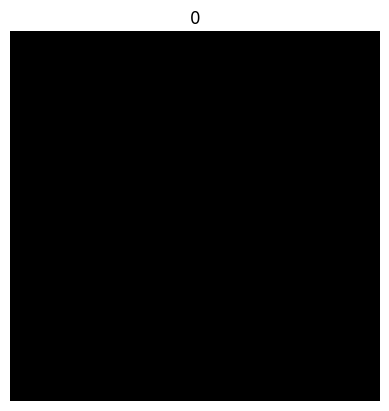

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

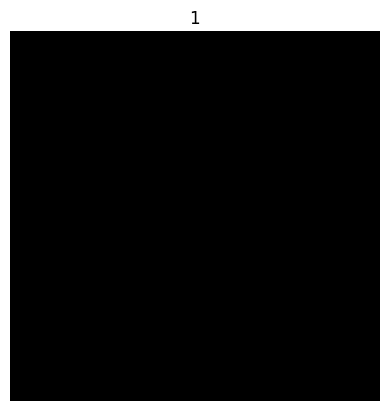

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

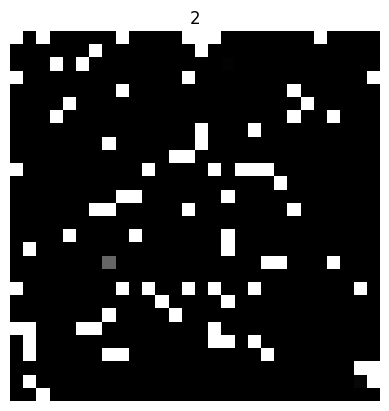

[255, 0, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

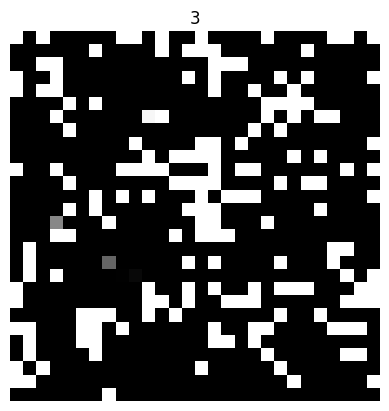

[255, 0, 255, 0, 0, 0, 0, 0, 255, 255, 0, 255, 0, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 255, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 255, 255, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 247, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 255, 255, 255, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 255, 25

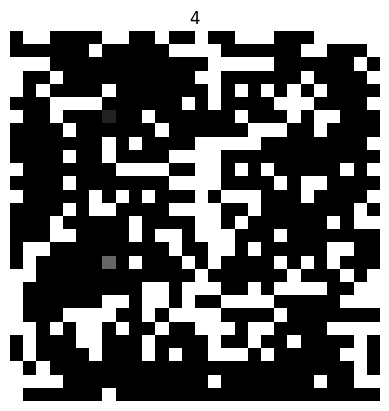

[0, 255, 255, 0, 0, 0, 0, 255, 255, 0, 0, 255, 0, 0, 255, 0, 0, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 255, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 255, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 255, 255, 0, 0, 255, 0, 0, 0, 34, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 253, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

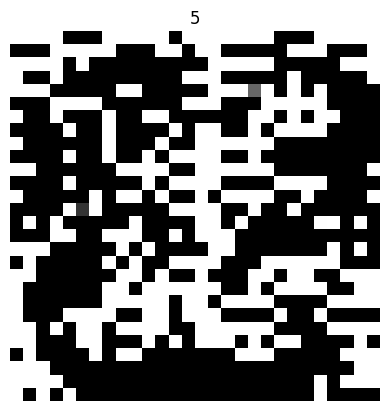

[255, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 255, 255, 0, 255, 255, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 255, 255, 255, 102, 255, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 255, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 255, 255, 0, 255, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 255, 0, 255, 255, 0, 0, 255, 0, 255, 255, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 0

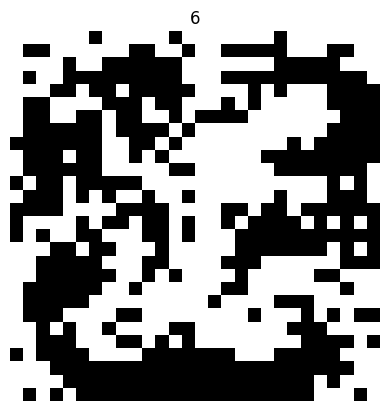

[255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 0, 255, 255, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 0, 255, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 255, 0, 255, 255, 255, 0, 0, 0, 0, 255, 0, 0, 255, 255, 255, 255, 0, 0, 0, 255, 0, 0, 255, 255, 255, 0, 255, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 255, 0, 0, 255, 255, 0, 0, 255, 0, 0, 255, 255, 0, 255, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 0, 2

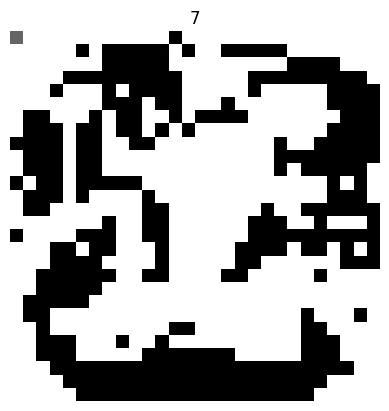

[101, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 0, 0, 0, 0, 1, 255, 0, 255, 255, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 255, 255, 255, 0, 255, 0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 255, 0, 0, 255, 255, 255, 0, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 255, 0, 0, 255, 255, 255, 0, 255, 0, 0, 255, 255, 0, 255, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 255, 0, 0, 255, 0, 255, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 255, 0, 0, 255, 255, 255,

In [ ]:
q1 = [models[1]]
check(q1)

sat


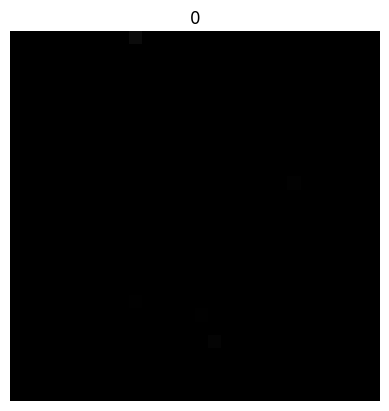

[0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,

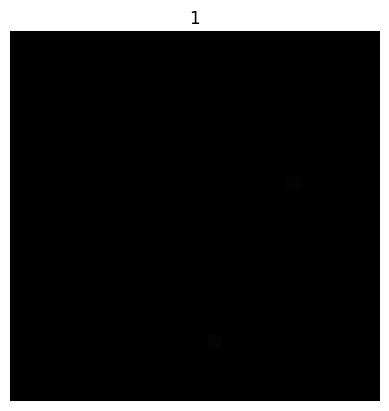

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 

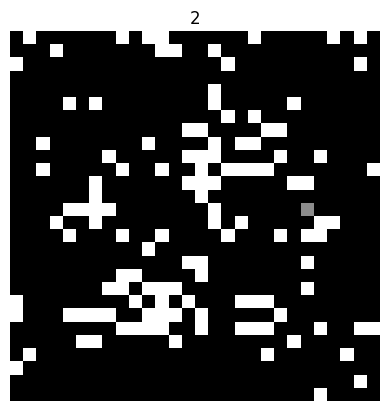

[0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 255, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0, 255, 0, 255, 255, 255, 255, 0, 0, 0, 0,

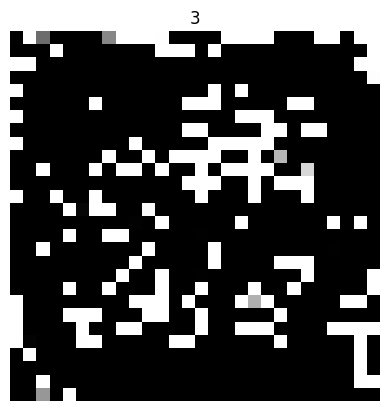

[1, 255, 108, 0, 0, 0, 0, 135, 255, 255, 255, 254, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 0, 255, 255, 0, 255, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 253, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 255, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 0, 255, 255, 255, 255, 0, 0, 255, 0, 183, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 255, 255, 0

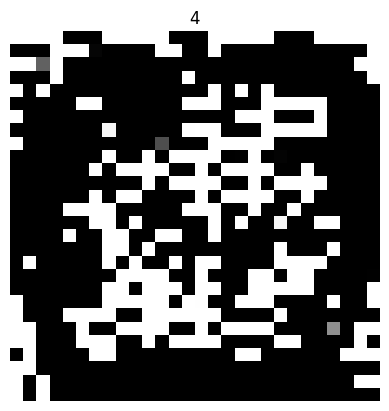

[255, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 255, 255, 255, 5, 0, 0, 0, 0, 255, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 97, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 246, 0, 0, 0, 0, 0, 254, 255, 255, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 78, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 0, 255, 255, 255, 255, 0, 1, 255, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
q01 = [models[0], models[1]]
check(q01)